In [17]:
%matplotlib inline

In [63]:
from brightway2 import *
from bw2analyzer import *
from bw2regional import *
import csv
import geopandas as gpd
import pandas as pd
import numpy as np
import pyprind
import seaborn as sb
import matplotlib.pyplot as plt

In [19]:
projects.set_current("LC IMPACT case study")

In [6]:
irrigation = [x for x in Database("ecoinvent") if 'irrigation' in x['name']]
crops = [x for x in Database("ecoinvent") 
         if x['name'] in ('sugarcane production', 'maize grain production')]

# Land Use

In [3]:
fu = {('Fuel comparison', 'sugarcane transport'): 1}
method = ('LC-IMPACT', 'Land Use', 'Occupation', 'Marginal', 'Certain')
# From previous notebook
presamples_path = '/Users/cmutel/Library/Application Support/Brightway3/LC-IMPACT-case-study.96518dd8fd4bda5eeaaa02b70dec68e3/presamples/e7c85547df894f42bc97520868aed105'

In [4]:
mc = MonteCarloLCA(fu, method, presamples=[presamples_path])
sugarcane_lu_sg = np.array([next(mc) for _ in range(500)])

In [105]:
from stats_arrays.random import MCRandomNumberGenerator

class MCXT(ExtensionTablesLCA):
    def solve_linear_system(self):
        return LCA.solve_linear_system(self)

    def load_data(self):
        self.load_lci_data()
        self.tech_rng = MCRandomNumberGenerator(self.tech_params, seed=self.seed)
        self.bio_rng = MCRandomNumberGenerator(self.bio_params, seed=self.seed)
        if self.presamples:
            self.presamples.reset_sequential_indices()

    def get_c_substitute(self):
        return (
            self.inv_mapping_matrix                 *
            self.distribution_normalization_matrix  *
            self.distribution_matrix                *
            self.xtable_matrix                      *
            self.geo_transform_normalization_matrix *
            self.geo_transform_matrix               *
            self.reg_cf_matrix
        ).T        

    def lcia_calculation(self):
        if not hasattr(self, "c_sub"):
            self.c_sub = self.get_c_substitute()
        self.characterized_inventory = self.c_sub.multiply(self.inventory)
    
    def __next__(self):
        if not hasattr(self, "tech_rng"):
            self.load_data()
            self.load_lcia_data()            
        self.rebuild_technosphere_matrix(self.tech_rng.next())
        self.rebuild_biosphere_matrix(self.bio_rng.next())

        if self.presamples:
            self.presamples.update_matrices()

        if not hasattr(self, "demand_array"):
            self.build_demand_array()

        self.lci_calculation()
        if self.lcia:
            self.lcia_calculation()
            return self.score
        else:
            return self.supply_array

In [13]:
mc = MCXT(fu, 
          method, 
          xtable='world-topo-ecoregions-sugarcane_landuse_intensity', 
          limitations={'activities': crops}
)
part_one = np.array([next(mc) for _ in pyprind.prog_bar(range(500))])

In [14]:
mc = MCXT(fu, 
          method, 
          xtable='world-topo-ecoregions-weighted-pop-density', 
          limitations={'activities': crops, 'activities mode': 'exclude'}
)
part_two = np.array([next(mc) for _ in pyprind.prog_bar(range(500))])

In [15]:
sugarcane_lu_sd = part_one + part_two

In [21]:
fu = {('Fuel comparison', 'maize transport'): 1}

In [22]:
mc = MonteCarloLCA(fu, method, presamples=[presamples_path])
maize_lu_sg = np.array([next(mc) for _ in range(500)])

In [23]:
mc = MCXT(fu, 
          method, 
          xtable='world-topo-ecoregions-maize_landuse_intensity', 
          limitations={'activities': crops}
)
part_one = np.array([next(mc) for _ in pyprind.prog_bar(range(500))])

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:03:17


In [24]:
mc = MCXT(fu, 
          method, 
          xtable='world-topo-ecoregions-weighted-pop-density', 
          limitations={'activities': crops, 'activities mode': 'exclude'}
)
part_two = np.array([next(mc) for _ in pyprind.prog_bar(range(500))])

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 01:12:20


In [25]:
maize_lu_sd = part_one + part_two

In [71]:
sugarcane_lu_sg.sort()
maize_lu_sg.sort()

s = sugarcane_lu_sg[25:-25]
m = maize_lu_sg[25:-25]

In [92]:
results = pd.DataFrame({'Sugarcane': s, 'Maize': m})

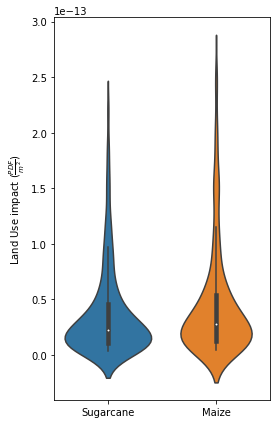

In [93]:
plt.figure(figsize=(4, 6))

sb.violinplot(data=results)

yticks = plt.yticks()[0]

plt.ylabel(r"Land Use impact $( \frac{PDF}{m^{2}} )$")
plt.tight_layout()
plt.savefig("land-use-sg.png", dpi=300)

In [94]:
results = pd.DataFrame({'Sugarcane': sugarcane_lu_sd, 'Maize': maize_lu_sd})

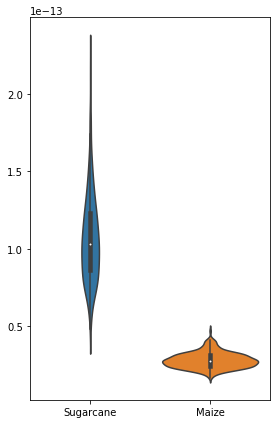

In [95]:
plt.figure(figsize=(4, 6))

plt.yticks(yticks)

sb.violinplot(data=results)
plt.tight_layout()
plt.savefig("land-use-sd.png", dpi=300)

# Water Use

In [131]:
method = ('LC-IMPACT', 'Water Use', 'Ecosystem Quality', 'Surface Water', 'Marginal', 'All')
fu = {('Fuel comparison', 'sugarcane transport'): 1}

In [132]:
mc = MonteCarloLCA(fu, method)
sugarcane_wu_sg = np.array([next(mc) for _ in pyprind.prog_bar(range(500))])

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:50


In [133]:
mc = MCXT(fu, 
          method, 
          xtable='world-topo-watersheds-eq-sw-all-sugarcane_water_intensity', 
          limitations={'activities': crops + irrigation}
)
part_one = np.array([next(mc) for _ in pyprind.prog_bar(range(500))])

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:03:09


In [134]:
mc = MCXT(fu, 
          method, 
          xtable='world-topo-watersheds-eq-sw-all-weighted-pop-density', 
          limitations={'activities': crops + irrigation, 'activities mode': 'exclude'}
)
part_two = np.array([next(mc) for _ in pyprind.prog_bar(range(500))])

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:03:26


In [135]:
sugarcane_wu_sd = part_one + part_two

In [136]:
fu = {('Fuel comparison', 'maize transport'): 1}

In [137]:
mc = MonteCarloLCA(fu, method)
maize_wu_sg = np.array([next(mc) for _ in pyprind.prog_bar(range(500))])

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:50


In [138]:
mc = MCXT(fu, 
          method, 
          xtable='world-topo-watersheds-eq-sw-all-maize_water_intensity', 
          limitations={'activities': crops + irrigation}
)
part_one = np.array([next(mc) for _ in pyprind.prog_bar(range(500))])

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:03:13


In [139]:
mc = MCXT(fu, 
          method, 
          xtable='world-topo-watersheds-eq-sw-all-weighted-pop-density', 
          limitations={'activities': crops + irrigation, 'activities mode': 'exclude'}
)
part_two = np.array([next(mc) for _ in pyprind.prog_bar(range(500))])

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:03:31


In [140]:
maize_wu_sd = part_one + part_two

In [141]:
sugarcane_wu_sg.sort()
maize_wu_sg.sort()

s = sugarcane_wu_sg[25:-25]
m = maize_wu_sg[25:-25]

In [150]:
results = pd.DataFrame({'Sugarcane': s, 'Maize': m})

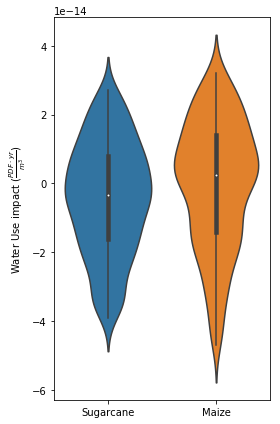

In [152]:
plt.figure(figsize=(4, 6))

sb.violinplot(data=results)

# plt.yticks(yticks)

plt.ylabel(r"Water Use impact $( \frac{PDF \cdot yr}{m^{3}} )$")
plt.tight_layout()
plt.savefig("water-use-sg.png", dpi=300)

In [144]:
results = pd.DataFrame({'Sugarcane': sugarcane_wu_sd, 'Maize': maize_wu_sd})

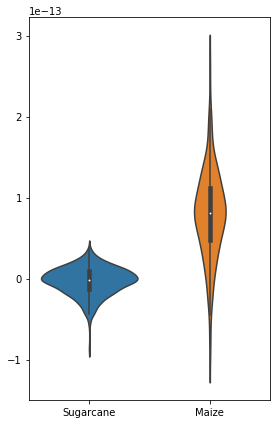

In [149]:
plt.figure(figsize=(4, 6))

yticks = plt.yticks()[0]

sb.violinplot(data=results)
plt.tight_layout()
plt.savefig("water-use-sd.png", dpi=300)